In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
# Ignore warnings
import warnings
warnings.simplefilter("ignore", category=Warning)


In [2]:
df = pd.read_csv('C:/Users/nikit/OneDrive/Desktop/data/household_power_consumption.txt', sep=';',low_memory=False, na_values=['nan','?'], nrows=1000000)

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
# Check for missing values
print(df.isnull().sum())

Date                        0
Time                        0
Global_active_power      3990
Global_reactive_power    3990
Voltage                  3990
Global_intensity         3990
Sub_metering_1           3990
Sub_metering_2           3990
Sub_metering_3           3990
dtype: int64


In [5]:
# Split date time difference into two columns
datetime_str = df['Date'] + ' ' + df['Time']

In [6]:
df['datetime'] = pd.to_datetime(datetime_str, format='%d/%m/%Y %H:%M:%S')

In [7]:
# Drop the original date and time columns
# df.drop(['Date', 'Time'], axis=1, inplace=True)

In [8]:
# Handle missing values
df.replace('?', np.nan, inplace=True)  # Replace '?' with NaN
df.dropna(inplace=True)  # Drop rows with missing values

In [9]:
# Time Based Features Engineering

# Add a new column for the hour of the day
df["Hours"] = df["datetime"].dt.hour

# Create a new column for the day of the week
df["Day"] = df["datetime"].dt.weekday

# Create a new column for the month of the year
df["Month"] = df["datetime"].dt.month

# Create a new column for the day of the month
df["Day_of_month"] = df["datetime"].dt.day

# Create day of the week feature (0=Monday, 6=Sunday)
df['Day_of_week'] = df['datetime'].dt.dayofweek



In [10]:
# Feature Engineering
# Calculate the active energy consumption
df["Active_energy_consumption"] = df["Global_active_power"] * 1000 / 60 - df["Sub_metering_1"] - df["Sub_metering_2"] - df["Sub_metering_3"]

# Create binary feature for weekend
df['is_weekend'] = (df['Day_of_week'] >= 5).astype(int)

# Calculate rolling mean of global active power over 3-hour window
df['rolling_mean_power'] = df['Global_active_power'].rolling(window=6).mean()
# Additional Feature Engineering
df["Active_power_ratio"] = df["Global_active_power"] / df["Voltage"]
df["Power_factor"] = df["Global_active_power"] / (df["Voltage"] * df["Global_intensity"])
df["Power_diff"] = df["Global_active_power"] - df["Global_reactive_power"]
df["Voltage_mean"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].mean(axis=1)
df["Voltage_std"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].std(axis=1)
df["Voltage_range"] = df["Voltage_std"] - df["Voltage_mean"]
df["Voltage_min"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].min(axis=1)
df["Voltage_max"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].max(axis=1)

In [11]:
df["Active_energy_consumption"].describe()

count    996010.000000
mean          9.669177
std          10.601850
min          -2.400000
25%           3.700000
50%           5.400000
75%          10.433333
max         124.833333
Name: Active_energy_consumption, dtype: float64

In [12]:
# Convert Global reactive power into categories
label_encoder = LabelEncoder()
df['Active_energy_consumption'] = label_encoder.fit_transform(
    df['Active_energy_consumption'].apply(
        lambda x: 'Low' if x < 3.8 else ('Medium' if x <= 10.36667 else 'High')
    )
)

<AxesSubplot: xlabel='Active_energy_consumption'>

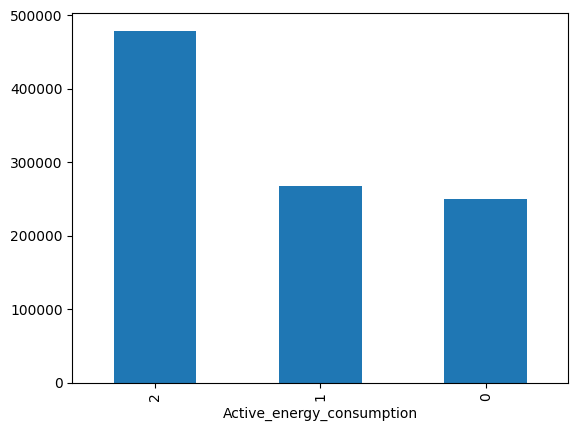

In [13]:
df['Active_energy_consumption'].value_counts().plot(kind='bar')

In [14]:
df['Active_energy_consumption'].value_counts()

Active_energy_consumption
2    479147
1    267099
0    249764
Name: count, dtype: int64

In [15]:
# drop the columns
df.drop(['Date','Time','datetime'], axis = 1, inplace=True)

In [16]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Hours', 'Day', 'Month', 'Day_of_month',
       'Day_of_week', 'Active_energy_consumption', 'is_weekend',
       'rolling_mean_power', 'Active_power_ratio', 'Power_factor',
       'Power_diff', 'Voltage_mean', 'Voltage_std', 'Voltage_range',
       'Voltage_min', 'Voltage_max'],
      dtype='object')

In [17]:
df.dropna(inplace=True)

In [18]:
y = df.pop('Active_energy_consumption')
X = df

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
datasets = [(X_train, "X_train"), (X_test, "X_test"), (y_train, "y_train"), (y_test, "y_test")]

for data, name in datasets:
    print(f"{name} shape:", data.shape)


X_train shape: (796804, 22)
X_test shape: (199201, 22)
y_train shape: (796804,)
y_test shape: (199201,)


In [21]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
import time
# Create a linear regression model
model = LogisticRegression(random_state=random_seed, verbose = 1)

# Measure time taken for training
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

# Measure time taken for prediction
start_time = time.time()
predictions = model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

print("Training Time:", training_time, "seconds")
print("Prediction Time:", prediction_time, "seconds")
print("Model Score:", model.score(X_test, y_test))

Training Time: 14.736066341400146 seconds
Prediction Time: 0.030924558639526367 seconds
Model Score: 0.98825809107384


Accuracy: 0.98825809107384
Precision: 0.9883355947602213
Recall: 0.98825809107384
F1 Score: 0.9882716096359779
Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00     50153
      Medium       0.97      0.99      0.98     53335
        High       0.99      0.98      0.99     95713

    accuracy                           0.99    199201
   macro avg       0.99      0.99      0.99    199201
weighted avg       0.99      0.99      0.99    199201



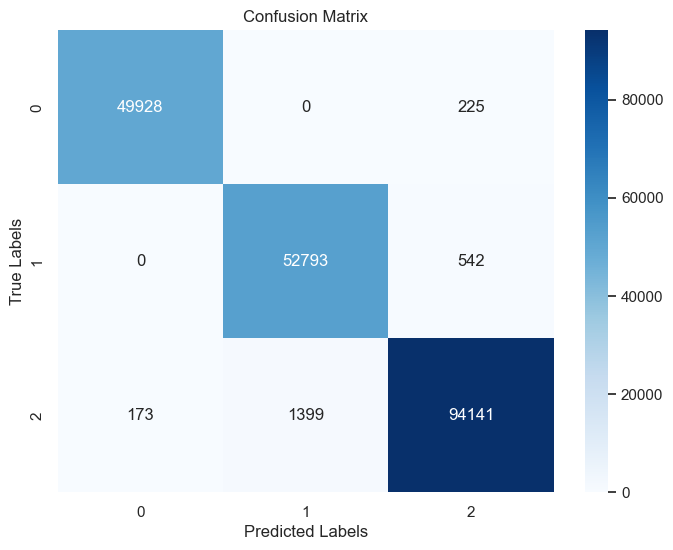

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_classification_model(model, X_test, y_test):
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'])
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    # print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    # Set style for seaborn
    sns.set(style="whitegrid")
    
    # Create a confusion matrix plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function with your trained model and test data
evaluate_classification_model(model, X_test, y_test)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb  # Import XGBoost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
import pandas as pd

# Create a dictionary of classification algorithms
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=random_seed),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1, random_state=random_seed),
    "Support Vector Machine": ExtraTreesClassifier(n_estimators=10, random_state=random_seed),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(random_state=random_seed) 
}

# Initialize lists to store performance metrics and time complexity
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
training_times = []

# Use tqdm to loop through models and track progress
for name, model in tqdm(classifiers.items()):
    print(f"Model: {name}")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)
    
    y_pred = model.predict(X_test)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# Create a DataFrame to store the performance metrics and time complexity
metrics_df = pd.DataFrame({
    "Algorithm": list(classifiers.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores,
    "Training Time (seconds)": training_times
})

metrics_df

  0%|          | 0/6 [00:00<?, ?it/s]

Model: Logistic Regression


 17%|█▋        | 1/6 [00:19<01:39, 19.99s/it]

Model: Decision Tree


 33%|███▎      | 2/6 [00:37<01:15, 18.77s/it]

Model: Random Forest


 50%|█████     | 3/6 [00:44<00:39, 13.20s/it]

Model: Support Vector Machine


 67%|██████▋   | 4/6 [00:54<00:23, 11.95s/it]

Model: K-Nearest Neighbors


 83%|████████▎ | 5/6 [06:16<02:03, 123.72s/it]

Model: XGBoost


100%|██████████| 6/6 [09:18<00:00, 93.10s/it] 


,Algorithm,Accuracy,Precision,Recall,F1 Score,Training Time (seconds)
0,Logistic Regression,0.988258,0.988336,0.988258,0.988272,19.705976
1,Decision Tree,0.995191,0.995191,0.995191,0.995191,17.669070
2,Random Forest,0.963399,0.964306,0.963399,0.963238,6.344111
3,Support Vector Machine,0.988855,0.988859,0.988855,0.988854,9.297903
4,K-Nearest Neighbors,0.922059,0.922263,0.922059,0.922146,0.108816
5,XGBoost,0.997058,0.997064,0.997058,0.997058,181.536316


In [25]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
X_test = pd.DataFrame(data=X_test, columns=X.columns)
# PredictX_test

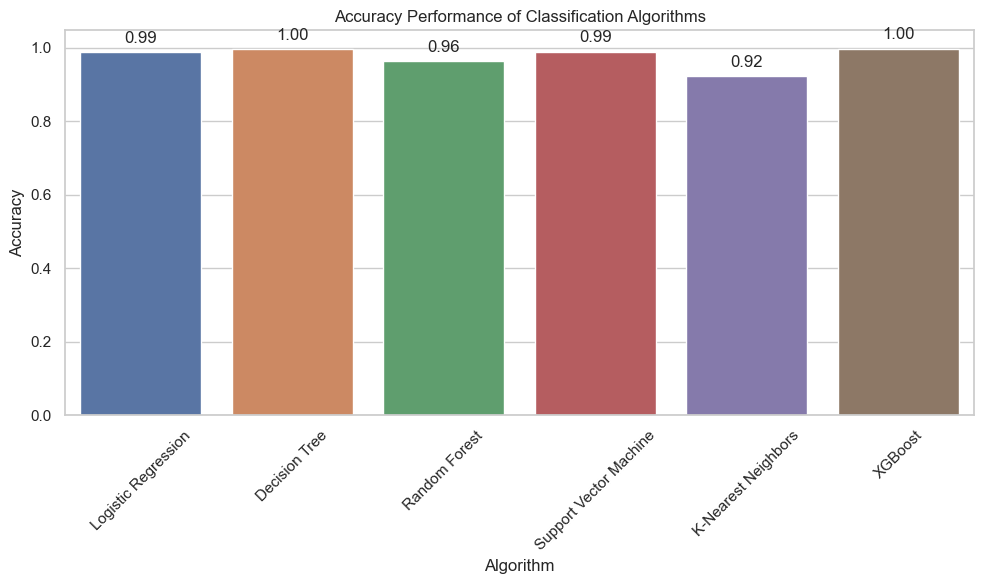

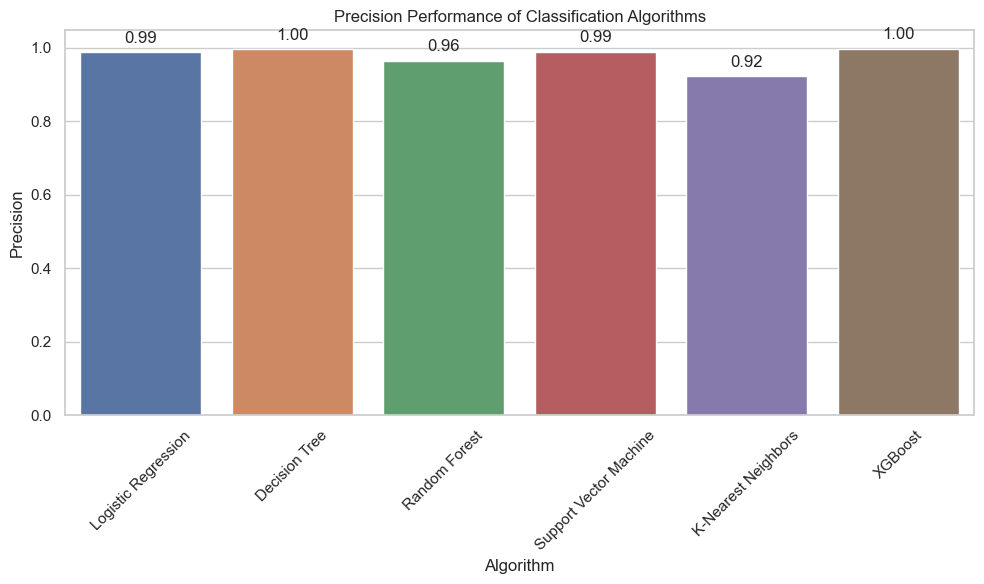

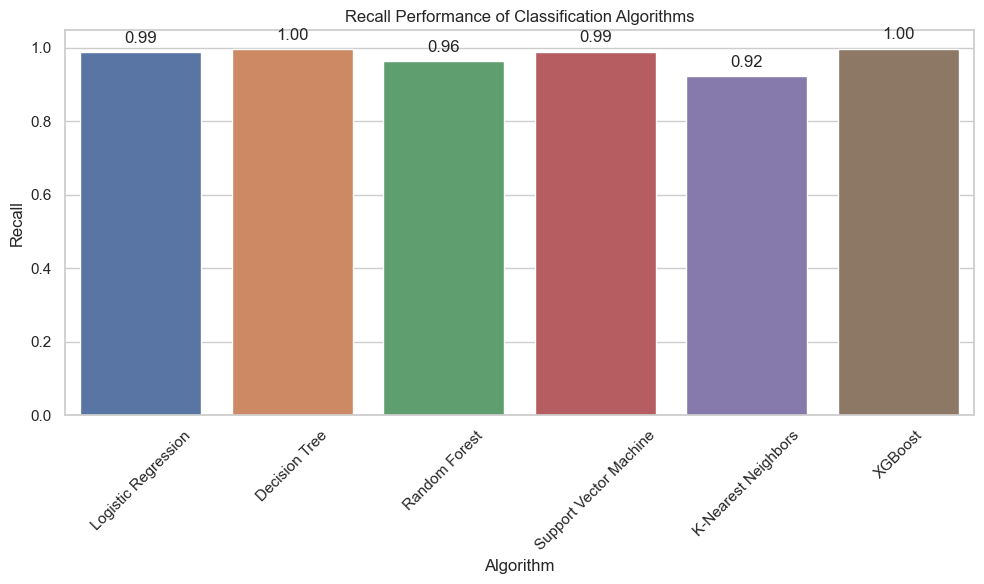

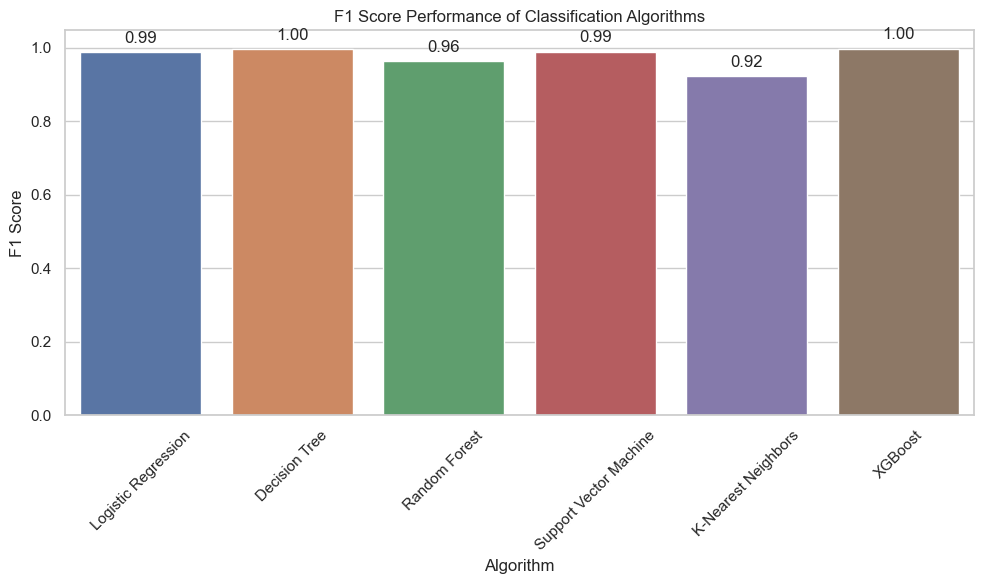

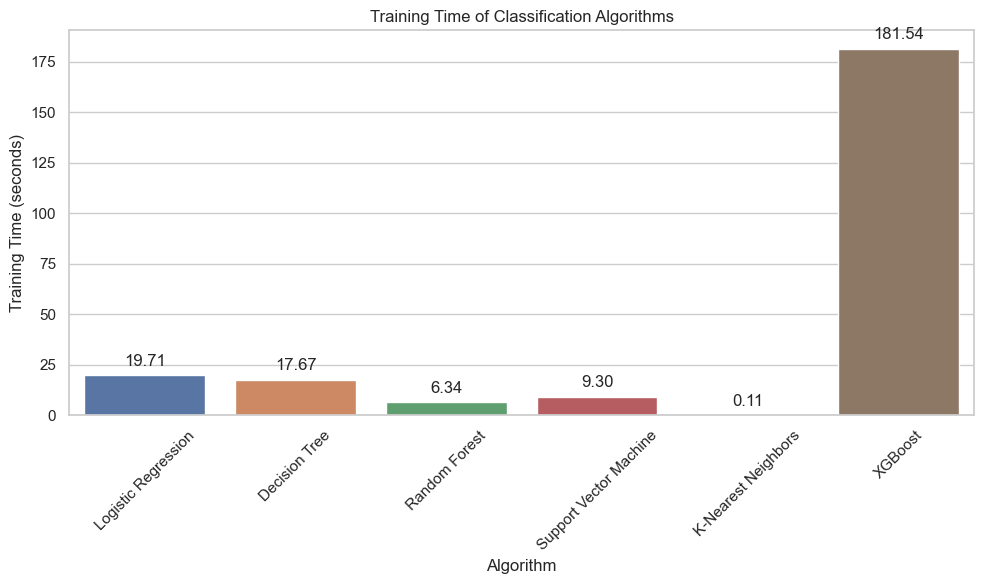

In [26]:
# Plot the performance metrics algorithm-wise
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_df, x="Algorithm", y="Accuracy")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Accuracy Performance of Classification Algorithms")
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".2f"), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="center", 
                xytext=(0, 10), 
                textcoords="offset points")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_df, x="Algorithm", y="Precision")
plt.xticks(rotation=45)
plt.ylabel("Precision")
plt.title("Precision Performance of Classification Algorithms")
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".2f"), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="center", 
                xytext=(0, 10), 
                textcoords="offset points")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_df, x="Algorithm", y="Recall")
plt.xticks(rotation=45)
plt.ylabel("Recall")
plt.title("Recall Performance of Classification Algorithms")
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".2f"), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="center", 
                xytext=(0, 10), 
                textcoords="offset points")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_df, x="Algorithm", y="F1 Score")
plt.xticks(rotation=45)
plt.ylabel("F1 Score")
plt.title("F1 Score Performance of Classification Algorithms")
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".2f"), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="center", 
                xytext=(0, 10), 
                textcoords="offset points")
plt.tight_layout()
plt.show()

# Plot Training Time (seconds)
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_df, x="Algorithm", y="Training Time (seconds)")
plt.xticks(rotation=45)
plt.ylabel("Training Time (seconds)")
plt.title("Training Time of Classification Algorithms")
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".2f"), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="center", 
                xytext=(0, 10), 
                textcoords="offset points")
plt.tight_layout()
plt.show()

In [27]:
# Find the best algorithm based on each metric
best_accuracy_index = metrics_df["Accuracy"].idxmax()
best_precision_index = metrics_df["Precision"].idxmax()
best_recall_index = metrics_df["Recall"].idxmax()
best_f1_index = metrics_df["F1 Score"].idxmax()
best_time_index = metrics_df["Training Time (seconds)"].idxmin()

best_accuracy_algorithm = metrics_df.loc[best_accuracy_index, "Algorithm"]
best_precision_algorithm = metrics_df.loc[best_precision_index, "Algorithm"]
best_recall_algorithm = metrics_df.loc[best_recall_index, "Algorithm"]
best_f1_algorithm = metrics_df.loc[best_f1_index, "Algorithm"]
best_time_algorithm = metrics_df.loc[best_time_index, "Algorithm"]

# Print the best algorithms for each metric
print(f"Best algorithm based on Accuracy: {best_accuracy_algorithm}")
print(f"Best algorithm based on Precision: {best_precision_algorithm}")
print(f"Best algorithm based on Recall: {best_recall_algorithm}")
print(f"Best algorithm based on F1 Score: {best_f1_algorithm}")
print(f"Best algorithm based on Time: {best_time_algorithm}")

# Use the best algorithm to make predictions
best_algorithm = classifiers[best_accuracy_algorithm]

# Train the best algorithm on the entire training data
best_algorithm.fit(X_train, y_train)

# Make predictions using the best algorithm
y_pred_best = best_algorithm.predict(X_test)

Best algorithm based on Accuracy: XGBoost
Best algorithm based on Precision: XGBoost
Best algorithm based on Recall: XGBoost
Best algorithm based on F1 Score: XGBoost
Best algorithm based on Time: K-Nearest Neighbors


In [28]:
# Save the trained model as a pickle file
import pickle


model_file_path  = 'C:/Users/nikit/OneDrive/Desktop/cls_model.pkl'
# Save the model using pickle
with open(model_file_path, 'wb') as model_file:
    pickle.dump(best_algorithm, model_file)

In [29]:
import pickle
# Specify the file path of the saved model
model_file_path = 'C:/Users/nikit/OneDrive/Desktop/cls_model.pkl'

# Load the model using pickle
with open(model_file_path, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

print("Model loaded successfully!")



Model loaded successfully!


In [30]:
# from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# explainer = ClassifierExplainer(best_algorithm, pd.DataFrame(X_test, columns=df.columns), y_test)
# ExplainerDashboard(explainer).run()

In [31]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

explainer = ClassifierExplainer(loaded_model, X_test, y_test)
db = ExplainerDashboard(explainer, simple=True)
db.run(port=9000)

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
model_output=='probability' does not work with multiclass XGBClassifier models, so settings model_output='logodds'...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Calculating shap values...
Generating layout...
Calculating confusion matrices...
Calculating prediction probabilities...
Calculating roc auc curves...
Calculating dependencies...
Calculating predictions...
Calculating metrics...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.127.53:9000


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=9000): Max retries exceeded with url: /_alive_95f23f2b-b2fe-4c7c-ba22-5acb2e1552f4 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D64FE59F10>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))

Accuracy: 0.9970582476995598
Precision: 0.9970638387009088
Recall: 0.9970582476995598
F1 Score: 0.9970581363518078
Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00     50153
      Medium       1.00      0.99      1.00     53335
        High       1.00      1.00      1.00     95713

    accuracy                           1.00    199201
   macro avg       1.00      1.00      1.00    199201
weighted avg       1.00      1.00      1.00    199201



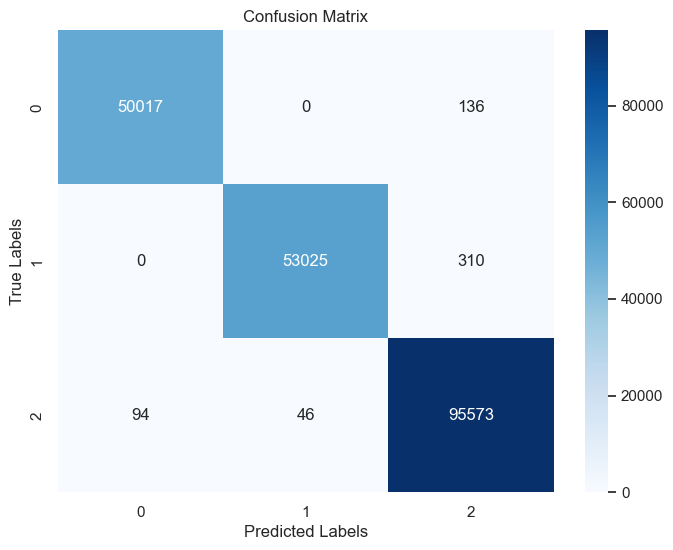

In [ ]:
# Call the function with your trained model and test data
evaluate_classification_model(loaded_model, X_test, y_test)

In [ ]:
db.terminate(9000)

Trying to shut down dashboard on port 9000...
Something seems to have failed: ('Connection aborted.', BadStatusLine('ÿ\x00\x00\x00\x00\x00\x00\x00\x01\x7fl\x00ost:9000\r\n'))
